In [9]:
import os
import cv2
import random
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil
import itertools
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [10]:
def preprocess(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    #new_image = thresh[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image

In [11]:
datadir = ['dataset/']
CATEGORIES = ['no','yes']
training_data_feature = []
training_data_label = []
IMG_SIZE = 120

def create_training_data():
    for DATADIR in datadir:
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category)
            class_num = CATEGORIES.index(category) 
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    image = preprocess(img_array)
                    new_array = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
                    new_array = new_array/255.0
                    training_data_feature.append(new_array)
                    training_data_label.append(class_num)
                except Exception as e:
                    pass
        
create_training_data()

In [12]:
training_data_feature = np.array(training_data_feature)
training_data_label = np.array(training_data_label)

In [13]:
X_train, X_test,y_train, y_test = train_test_split(training_data_feature,training_data_label, test_size=0.1,random_state=32)

# MODEL 1

In [14]:
model = Sequential()

model.add(Conv2D(64, (3,3), (1,1), input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #to convert 3D feature map to 1D
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
76/76 [==============================] - 25s 319ms/step - loss: 0.8953 - accuracy: 0.5536 - val_loss: 0.5359 - val_accuracy: 0.7074
Epoch 2/10
76/76 [==============================] - 25s 326ms/step - loss: 0.4244 - accuracy: 0.8016 - val_loss: 0.3445 - val_accuracy: 0.8704
Epoch 3/10
76/76 [==============================] - 25s 328ms/step - loss: 0.2545 - accuracy: 0.9061 - val_loss: 0.2351 - val_accuracy: 0.9222
Epoch 4/10
76/76 [==============================] - 25s 328ms/step - loss: 0.1616 - accuracy: 0.9372 - val_loss: 0.2074 - val_accuracy: 0.9222
Epoch 5/10
76/76 [==============================] - 25s 324ms/step - loss: 0.0970 - accuracy: 0.9658 - val_loss: 0.1442 - val_accuracy: 0.9593
Epoch 6/10
76/76 [==============================] - 25s 325ms/step - loss: 0.0414 - accuracy: 0.9906 - val_loss: 0.1343 - val_accuracy: 0.9519
Epoch 7/10
76/76 [==============================] - 25s 324ms/step - loss: 0.0271 - accuracy: 0.9959 - val_loss: 0.1340 - val_accuracy: 0.9704

In [16]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10/10 [==============================] - 1s 103ms/step - loss: 0.2903 - accuracy: 0.9533
Test loss: 0.29033994674682617
Test accuracy: 0.95333331823349


Text(0.5, 1.0, '[0]')

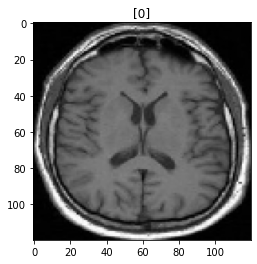

In [18]:
img_path = 'test/'
pred = []

for x in os.listdir(img_path): 
    path = os.path.join(img_path,x)
    test_image = cv2.imread(path)
    test_image = preprocess(test_image)
    new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
    new_array = new_array/255.0
    test_image = np.array(new_array)
    pred.append(test_image)

pred = np.array(pred)
ynew = model.predict_classes(pred)



plt.imshow(pred[0])
plt.title(ynew[0])

In [19]:
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

array([[140,   8],
       [  6, 146]])

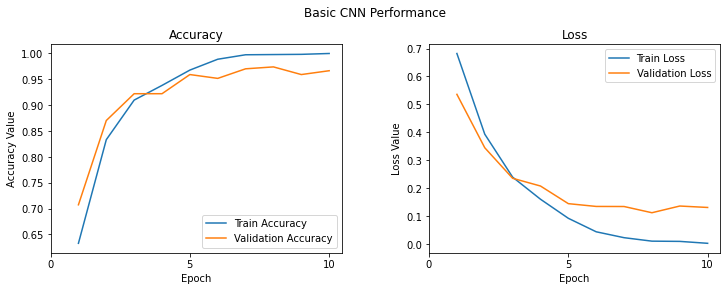

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## MODEL 2

In [21]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
history = model2.fit(X_train,y_train,epochs=10,batch_size=64,validation_split=0.1)

Epoch 1/10
38/38 [==============================] - 80s 2s/step - loss: 0.7021 - accuracy: 0.6530 - val_loss: 0.6509 - val_accuracy: 0.5852
Epoch 2/10
38/38 [==============================] - 79s 2s/step - loss: 0.4219 - accuracy: 0.8222 - val_loss: 0.5320 - val_accuracy: 0.7407
Epoch 3/10
38/38 [==============================] - 81s 2s/step - loss: 0.2739 - accuracy: 0.8926 - val_loss: 0.4871 - val_accuracy: 0.7444
Epoch 4/10
38/38 [==============================] - 80s 2s/step - loss: 0.1870 - accuracy: 0.9247 - val_loss: 0.3435 - val_accuracy: 0.8778
Epoch 5/10
38/38 [==============================] - 78s 2s/step - loss: 0.1406 - accuracy: 0.9532 - val_loss: 0.7880 - val_accuracy: 0.6370
Epoch 6/10
38/38 [==============================] - 76s 2s/step - loss: 0.1337 - accuracy: 0.9534 - val_loss: 0.2526 - val_accuracy: 0.9074
Epoch 7/10
38/38 [==============================] - 75s 2s/step - loss: 0.0894 - accuracy: 0.9667 - val_loss: 0.6639 - val_accuracy: 0.7148
Epoch 8/10
38/38 [==

In [23]:
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10/10 [==============================] - 2s 174ms/step - loss: 0.3554 - accuracy: 0.8367
Test loss: 0.35542693734169006
Test accuracy: 0.8366666436195374


/Users/egemenakbal/opt/miniconda3/envs/tfp-gpu/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/egemenakbal/opt/miniconda3/envs/tfp-gpu/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0]')

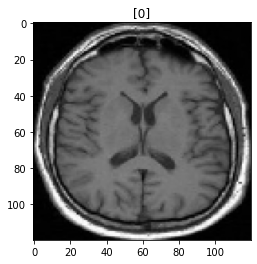

In [24]:
img_path = 'test/'
pred = []

for x in os.listdir(img_path): 
    path = os.path.join(img_path,x)
    test_image = cv2.imread(path)
    test_image = preprocess(test_image)
    new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
    new_array = new_array/255.0
    test_image = np.array(new_array)
    pred.append(test_image)

pred = np.array(pred)
ynew = model.predict_classes(pred)

plt.imshow(pred[0])
plt.title(ynew[0])

In [25]:
predictions = model2.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

array([[144,   4],
       [ 45, 107]])

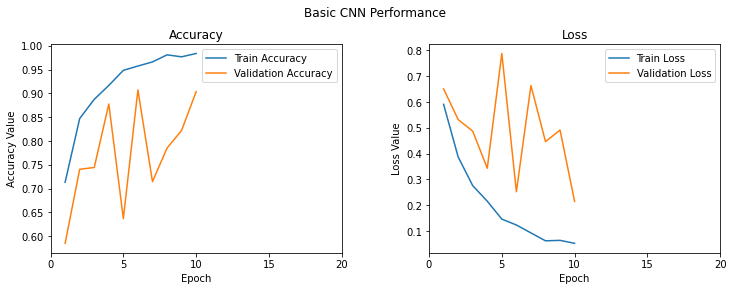

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")